In [1]:
import multiprocessing, cv2, os, sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from libvisu import *
sys.path.append(os.path.abspath('ABCImaging'))
from ABCImaging.libimage import fetchImagesPaths
from ABCImaging.VideoManagment.videolib import generateVideoFromList
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set a wide width for display
pd.set_option('display.colheader_justify', 'center')  # Align column headers
from dask.distributed import Client
# Start a client using all CPUs of this machine
client = Client()
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-m2kk774f', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/scheduler-wtph7959', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-f5z56arj', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-0bmx4nm3', purging
INFO:distributed.diskutils:Found stale lock file and directory '/var/folders/w2/m4mvm5pj37107n10n7fs6sd80000gr/T/dask-scratch-space/worker-vo2z_4am', purging
INFO:distributed.

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58634,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:58645,Total threads: 3
Dashboard: http://127.0.0.1:58651/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:58637,


## Configuration

In [2]:
# Path to the folder containing the pictures
rootpath_imgs = '/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/'                         # For images
rootpath_data = 'data/2025-10-03_10-21_influxdb_data.csv'  # For CO2, htr and tmp data
hive_nb = "1" 
t_res = "5min" # Image time resolution. Change only if images are not taken every minute. Use frame_drop to keep only some frames, not this.

first_dt = "251002-083000Z"
last_dt = "251003-100000Z"
frame_drop = 5 # We keep 1 frame every frame_drop frames. Put one to keep all frames.

## Running

### Image fetching

In [3]:
# Get the target dt (for which we need an image, data, etc.)
datetimes = pd.date_range(start=pd.to_datetime(first_dt, format='%y%m%d-%H%M%S%z'), end=pd.to_datetime(last_dt, format='%y%m%d-%H%M%S%z'), freq=t_res)
datetimes = datetimes[::frame_drop]

imgs_paths = fetchImagesPaths(rootpath_imgs, datetimes, hive_nb)
print(f"Found {len(imgs_paths)} images for hive {hive_nb} between {first_dt} and {last_dt}.")

Found 62 images for hive 1 between 251002-083000Z and 251003-100000Z.


### tmp fetching

In [4]:
# We fetch the thermal and other sensory data from the hive, for both RPis.
rootpath_data = os.path.abspath(rootpath_data)          # Absolute path to the data
hive_data = extractData(rootpath_data, int(hive_nb), datetimes, verbose=False) # Restricted to our time frame and hive
upper, lower = generateThermalDF(hive_data)   # Only tmp data, in a format that can be used by ThermalFrame

# Seek the max and min values of the tmp data, in both upper and lower hives
max_temp = max(upper.max().max(), lower.max().max())
min_temp = min(upper.min().min(), lower.min().min())
print("Max temperature in the selected time range: ", max_temp)
print("Min temperature in the selected time range: ", min_temp)
print(lower.head())

Max temperature in the selected time range:  36.796875
Min temperature in the selected time range:  14.46484375
                              t00        t01        t02        t03        t04        t05        t06        t07        t08        t09        t10        t11        t12        t13        t14        t15        t16        t17        t18        t19        t20        t21        t22        t23        t24        t25        t26        t27        t28        t29        t30        t31        t32        t33        t34        t35        t36        t37        t38        t39        t40        t41        t42        t43        t44        t45        t46        t47        t48        t49        t50        t51        t52        t53        t54        t55        t56        t57        t58        t59     t60  t61  t62  t63
_time                                                                                                                                                                                 

### Metabolic data fetching

In [5]:
# Now we fetch the metabolic data
co2_data =generateMetabolicDF(hive_data)
print(co2_data.head())

                              ul       ur         ll         lr  
_time                                                            
2025-10-02 08:30:00+00:00  7168.417  3262.0  11617.560000  1539.0
2025-10-02 08:55:00+00:00  5059.789  3382.0   7716.720333  1466.0
2025-10-02 09:20:00+00:00  8004.018  5415.0  13966.420000   630.0
2025-10-02 09:45:00+00:00  7593.751  2492.0  10943.620000  2118.0
2025-10-02 10:10:00+00:00  8050.977  5043.0  12333.580000  1549.0


### htr fetching

In [ ]:
# Alternative used now:
upper_htr = hive_data[(hive_data["inhive_loc"] == "upper") & (hive_data["_measurement"] == "htr")]
lower_htr = hive_data[(hive_data["inhive_loc"] == "lower") & (hive_data["_measurement"] == "htr")]
# Drop the _measurement column
upper_htr = upper_htr.drop(columns=["_measurement"])
lower_htr = lower_htr.drop(columns=["_measurement"])
print(upper_htr) # TODO: it is missing columns. Check why, and how we can avoid it from breaking the automation part at the bottom of the nb !!
print(lower_htr)

                                    _time             _value    _field  board_id geo_loc  hive_num inhive_loc          mcu_uuid          phys_loc  rpi_num   serial_id    valid  DeltaT actuator_instance content  filling_density
_time                                                                                                                                                                                                                             
2025-10-02 08:30:00+00:00 2025-10-02 08:30:00+00:00  16.36719  avg_temp   abc03    EPFL       1       upper    2191217016663093217343026   bass       1     /dev/ttyACM0  <NA>     0.0          h02        Unknown      Unknown   
2025-10-02 08:30:00+00:00 2025-10-02 08:30:00+00:00   0.00000       pwm   abc03    EPFL       1       upper    2191217016663093217343026   bass       1     /dev/ttyACM0  <NA>     0.0          h06        Unknown      Unknown   
2025-10-02 08:30:00+00:00 2025-10-02 08:30:00+00:00   0.00000       pwm   abc03    EPFL     

### Plotting

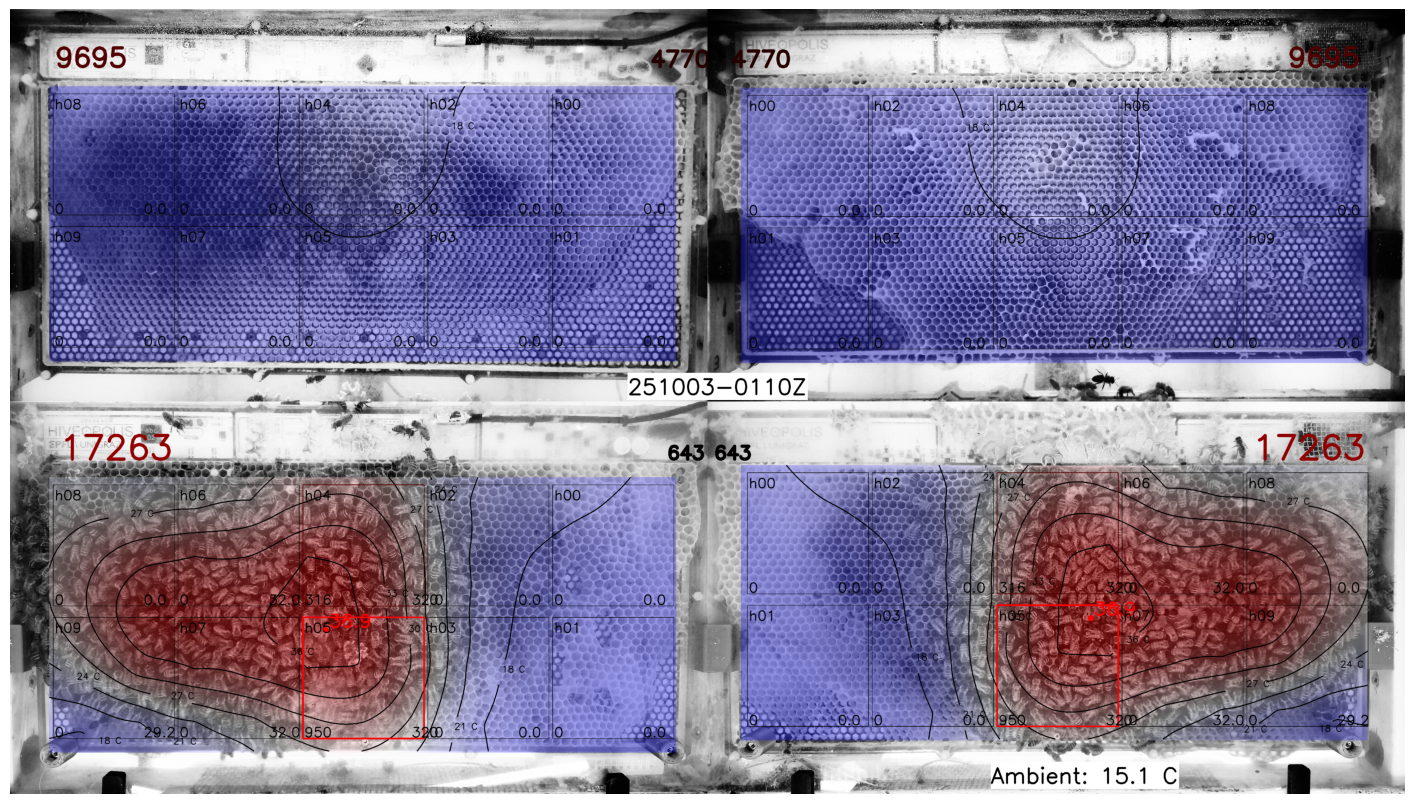

In [7]:
vmax = max_temp
vmin = min_temp
# For a random time frame, generate the image of the hive and the thermal plot side by side with matplotlib
# This is just to check that everything is working fine
plt.figure(figsize=(18, 12))
frame = 40 # Frame within datetimes
dt = datetimes[frame]
_imgs_paths = imgs_paths.loc[dt].to_numpy()
imgs_names = [str(_imgs_paths[i]).split("/")[-1][:-4] for i in range(len(_imgs_paths))]
# Read the images using cv2
current_imgs = [cv2.imread(_imgs_paths[i], cv2.IMREAD_GRAYSCALE) if _imgs_paths[i] is not None else np.zeros((2592,4608), np.uint8) for i in range(len(_imgs_paths))]
hs_1 = Hive(dt, current_imgs, False, imgs_names,ThermalFrame(upper.loc[dt].to_numpy(dtype="float64")),ThermalFrame(lower.loc[dt].to_numpy()),co2_data.loc[dt],upper_htr.loc[dt],lower_htr.loc[dt])
contours = list(range(12, 37, 3))
snapshot = hs_1.snapshot(v_max=vmax,v_min=vmin,contours=contours, annotate_contours = True, annotate_names=False, thermal_transparency=0.35)
plt.imshow(snapshot,cmap='gray')
plt.axis('off') 
plt.show()

### Automation

In [8]:
final_imgs = []
print("Generating frames...")
for dt in tqdm(datetimes):
    _imgs_paths = imgs_paths.loc[dt].to_numpy()
    imgs_names = [str(_imgs_paths[j]).split("/")[-1][:-4] for j in range(len(_imgs_paths))]
    # Read the images using cv2
    current_imgs = []
    for _img_path in _imgs_paths:
        if _img_path is not None:
            img = cv2.imread(_img_path, cv2.IMREAD_GRAYSCALE)
            current_imgs.append(img)
        else:
            current_imgs.append(np.zeros((2592,4608), np.uint8))
            
    hs = Hive(dt, current_imgs, False, imgs_names, ThermalFrame(upper.loc[dt].to_numpy()), ThermalFrame(lower.loc[dt].to_numpy()), co2_data.loc[dt], upper_htr.loc[dt], lower_htr.loc[dt])
    snapshot = hs.snapshot(v_max=max_temp, v_min=min_temp,contours=contours,thermal_transparency=0.4)

    final_imgs.append(snapshot)

# Change frames from rgb to bgr
print("Convert frames to bgr...")
for i in tqdm(range(len(final_imgs))):
    final_imgs[i] = cv2.cvtColor(final_imgs[i], cv2.COLOR_RGB2BGR)

dest = "outputVideos/"
# Make this a global path
print("Saving video...")
generateVideoFromList(final_imgs, dest="outputVideos/", name="hive" + hive_nb + "_" + first_dt + "_" + last_dt, fps=10, grayscale=False)

# Cleanup step to release resources
multiprocessing.active_children()

Generating frames...


 81%|████████  | 50/62 [00:58<00:14,  1.17s/it]


KeyError: Timestamp('2025-10-03 05:20:00+0000', tz='UTC')